In [10]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
from sklearn.model_selection import train_test_split
import glob
import os
from mpl_toolkits.mplot3d import Axes3D

In [6]:
# Path to the data folder
data_path = "Mod7_data/data"
file_pattern = os.path.join(data_path, "fof_subhalo_tab_000.*.hdf5") 
files = sorted(glob.glob(file_pattern))

# Loop through all files
# for file in files:
#     with h5py.File(file, 'r') as f:
#         print(f"File: {file}")

In [19]:
with h5py.File(files[0], 'r') as f: #files[0] = Mod7_data/data/fof_subhalo_tab_000.0.hdf5 (1st data file)
    data = f['Subhalo'].keys()   
    print(data)

<KeysViewHDF5 ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'SubhaloStarMetallicityHalfRad', 'SubhaloStarMetallicityM

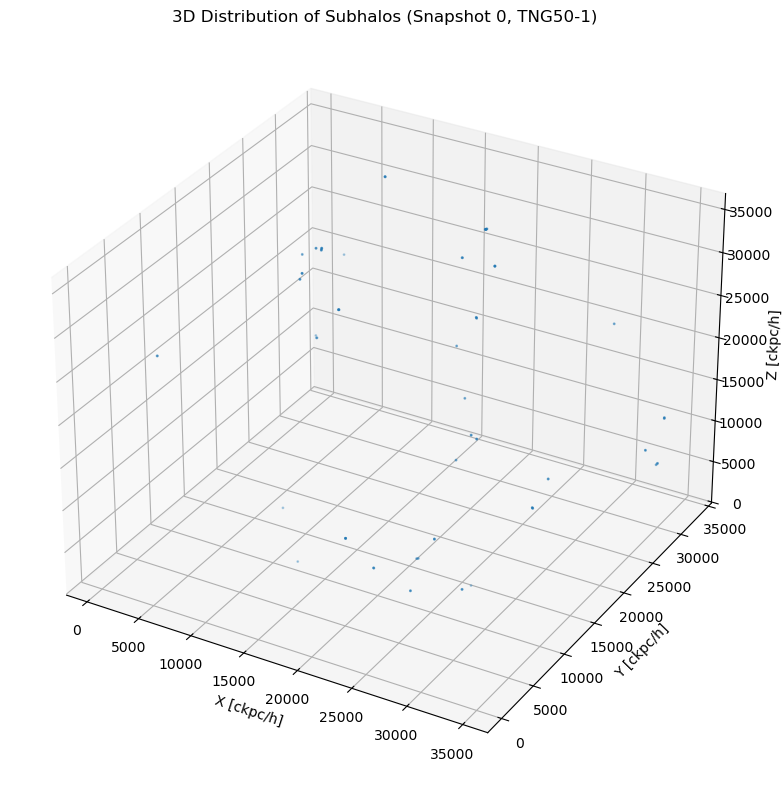

In [20]:
with h5py.File(files[0], 'r') as f:
    pos = f['Subhalo']['SubhaloPos'][:]  # shape: (N, 3)

# 2D projection
# if pos.shape[0] > 10000:
#     idx = np.random.choice(pos.shape[0], 10000, replace=False)
#     pos = pos[idx]

# Plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=1, alpha=0.3)

ax.set_xlabel('X [ckpc/h]')
ax.set_ylabel('Y [ckpc/h]')
ax.set_zlabel('Z [ckpc/h]')
ax.set_title('3D Distribution of Subhalos (Snapshot 0, TNG50-1)')
plt.tight_layout()
plt.show()


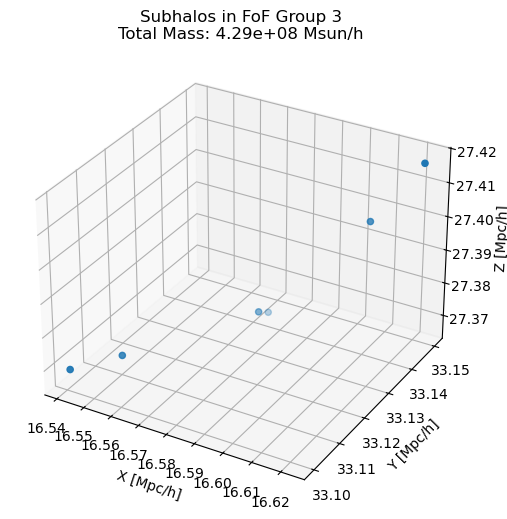

In [21]:
with h5py.File(files[0], 'r') as f:
    subhalo_pos = f["Subhalo"]["SubhaloPos"][:]      # (N, 3)
    subhalo_grnr = f["Subhalo"]["SubhaloGrNr"][:]    # (N,)
    group_mass = f["Group"]["GroupMass"][:] * 1e10    # Msun/h

# Choose a specific FoF group (e.g. group 0)
group_id = 3
mask = subhalo_grnr == group_id
group_subhalo_pos = subhalo_pos[mask]

# Optional: convert to Mpc/h
group_subhalo_pos /= 1000.0

# Plot 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(group_subhalo_pos[:, 0], group_subhalo_pos[:, 1], group_subhalo_pos[:, 2], s=20)

ax.set_title(f"Subhalos in FoF Group {group_id}\nTotal Mass: {group_mass[group_id]:.2e} Msun/h")
ax.set_xlabel("X [Mpc/h]")
ax.set_ylabel("Y [Mpc/h]")
ax.set_zlabel("Z [Mpc/h]")
plt.show()

## Subhalos are galaxy or galaxy-groups which can be considered as nodes for our GNN study. And the keys under subhalo directory can be used as different features for a specific node.

### Define feature matrix: considered only subhalo-BH mass and subhalo mass as features

In [22]:
all_bh_mass = []
all_mass = []

for file in files:
    with h5py.File(file, 'r') as f:
        bh_mass = f['Subhalo']['SubhaloBHMass'][:]
        mass = f['Subhalo']['SubhaloMass'][:]
        
        all_bh_mass.append(bh_mass)
        all_mass.append(mass)

# Concatenate across all files
SubhaloBHMass = np.concatenate(all_bh_mass)
SubhaloMass = np.concatenate(all_mass)

# Stack them into a feature matrix: shape (num_subhalos_total, 2)
Features = np.stack([SubhaloBHMass, SubhaloMass], axis=1)

### Define edges: So we need to know the location of all nodes (subhalos) and will use k-nearest neighbours to connect them

In [23]:
all_pos = []

for file in files:
    with h5py.File(file, 'r') as f:
        pos = f['Subhalo']['SubhaloPos'][:]  # shape: (N, 3)
        all_pos.append(pos)

SubhaloPos = np.concatenate(all_pos)  # shape: (total_N, 3)

In [24]:
from sklearn.neighbors import NearestNeighbors

k = 10  # Number of neighbors per node

knn = NearestNeighbors(n_neighbors=k+1)  # +1 because self is included
knn.fit(SubhaloPos)
distances, indices = knn.kneighbors(SubhaloPos) #indices is shape (N, k+1) where each row contains the indices of the nearest neighbors (including the node itself at index 0).

### Building edge index

In [25]:
# Skip self-edges: use indices[:, 1:]
src = np.repeat(np.arange(indices.shape[0]), k)
dst = indices[:, 1:].flatten()

edge_index = torch.tensor([src, dst], dtype=torch.long)

/var/folders/mm/s5km6vn901x3vgdp6rtxxh_40000gn/T/ipykernel_66400/196568139.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  edge_index = torch.tensor([src, dst], dtype=torch.long)


### Building PyTorch Geometric Data Object

### Node prediction (1 if BH mass is large relative to total mass)

In [84]:
from torch_geometric.data import Data

#data.y = labels
x = torch.tensor(Features, dtype=torch.float) #node features = [num_nodes, num_features]
# Label: 1 if BH mass is large relative to total mass
#labels = (x[:, 1] > 2.7).long()
# threshold = torch.quantile(x[:, 1], 0.8)
# labels = (x[:, 1] > threshold).long()

bh_mass = x[:, 1]
print(bh_mass)

labels = torch.full_like(bh_mass, fill_value=-1, dtype=torch.long)  # init with -1
labels[bh_mass < 1.4] = 0   # White Dwarf
labels[(bh_mass >= 1.4) & (bh_mass <= 2.7)] = 1  # Neutron Star

# Optional: mask out invalid examples (e.g., BH mass > 2.7)
valid_mask = labels != -1

# Filter data for valid nodes
x_valid = x[valid_mask]
edge_index_valid = edge_index[:, valid_mask[edge_index[0]] & valid_mask[edge_index[1]]]
labels_valid = labels[valid_mask]



data = Data(x=x_valid, edge_index=edge_index, y=labels_valid) 
#data.y = labels

tensor([0.0209, 0.0111, 0.0063,  ..., 0.0017, 0.0017, 0.0016])


### Visualize the graph data (taking long time to generate the graphical input data)

In [29]:
# import networkx as nx
# # Convert to NetworkX graph
# G = nx.Graph()
# edge_list = data.edge_index.t().tolist()  # Convert edge_index to list of edges

# # Add nodes with attributes (features)
# for i, feature in enumerate(data.x):
#     G.add_node(i, feature=feature.numpy())

# # Add edges
# G.add_edges_from(edge_list)

# # Draw the graph
# plt.figure(figsize=(8, 8))
# pos = nx.spring_layout(G)  # Spring layout for better node spacing
# nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=15, font_weight='bold', edge_color='gray')

# # Show the plot
# plt.show()

In [72]:
data.train_mask = torch.rand(data.num_nodes) < 0.8  # 80% train
data.test_mask = ~data.train_mask

In [73]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(2, 64)
        self.conv2 = GCNConv(64, 64)
        self.conv3 = GCNConv(64, 32)
        self.conv4 = GCNConv(32, 2)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

In [74]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

for epoch in range(101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)                # Forward pass
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Train loss
    loss.backward()
    optimizer.step()

    # Evaluate
    model.eval()
    _, pred = out.max(dim=1)  # Get predicted classes
    correct = pred[data.test_mask] == data.y[data.test_mask]
    acc = int(correct.sum()) / int(data.test_mask.sum())

    if epoch % 20 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}')

Epoch 000, Loss: 0.6931, Test Acc: 1.0000
Epoch 020, Loss: 0.0000, Test Acc: 1.0000
Epoch 040, Loss: 0.0000, Test Acc: 1.0000
Epoch 060, Loss: 0.0000, Test Acc: 1.0000
Epoch 080, Loss: 0.0000, Test Acc: 1.0000
Epoch 100, Loss: 0.0000, Test Acc: 1.0000


In [75]:
model.eval()
final_output = model(data.x, data.edge_index)
predicted_labels = final_output.argmax(dim=1)

In [76]:
print(final_output)

tensor([[  0.0000, -23.0770],
        [  0.0000, -25.1375],
        [  0.0000, -22.5501],
        ...,
        [  0.0000, -19.7714],
        [  0.0000, -17.3951],
        [  0.0000, -17.4987]], grad_fn=<LogSoftmaxBackward0>)


In [77]:
print(predicted_labels)

tensor([0, 0, 0,  ..., 0, 0, 0])


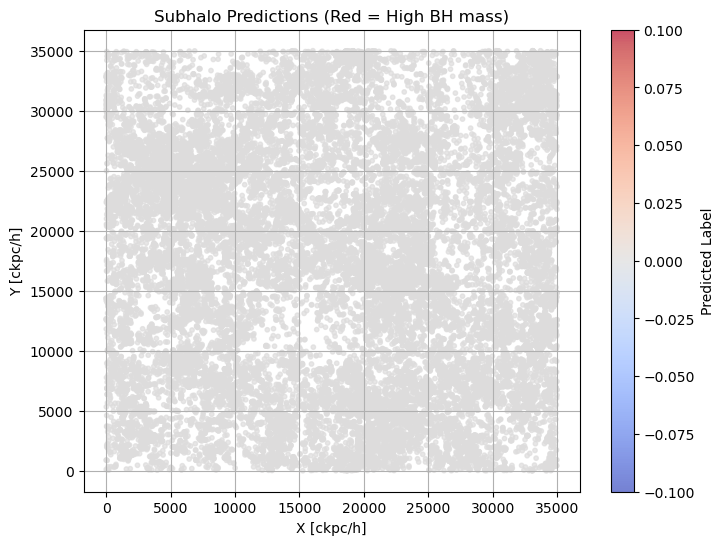

In [78]:
pos = SubhaloPos  # shape (N, 3) or (N, 2) if projected

# Use only 2D projection for scatter
x_coords = pos[:, 0]
y_coords = pos[:, 1]

# Convert tensors to numpy for plotting
pred_np = predicted_labels.cpu().numpy()
true_np = data.y.cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=pred_np, cmap='coolwarm', s=10, alpha=0.7, label='Predicted')
plt.xlabel('X [ckpc/h]')
plt.ylabel('Y [ckpc/h]')
plt.title('Subhalo Predictions (Red = High BH mass)')
plt.grid(True)
plt.colorbar(label='Predicted Label')
plt.show()

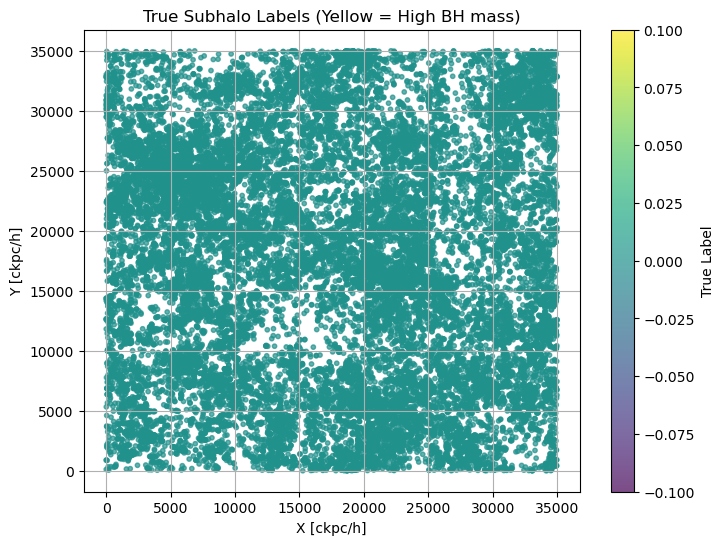

In [79]:
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=true_np, cmap='viridis', s=10, alpha=0.7, label='Ground Truth')
plt.xlabel('X [ckpc/h]')
plt.ylabel('Y [ckpc/h]')
plt.title('True Subhalo Labels (Yellow = High BH mass)')
plt.grid(True)
plt.colorbar(label='True Label')
plt.show()